# Equity Technical Charting

In [2]:
import warnings
warnings.filterwarnings('ignore')

!pip -q --disable-pip-version-check install yfinance
import yfinance as yf
import pandas as pd 
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime 

## Enter stock tickers here:

In [3]:
my_stocks = [
'SPY',
'IWN',
'VNQ',
'ACN',
'AMZN',
'AAPL',
'ADBE',
'BAC',
'BBY',
'COF',
'COST',
'DIS',
'EQIX',
'GOOG',
'GS',
'HAL',
'HCA',
'LUMN',
'MSFT',
'NFLX',
'NVDA',
'PG',
'PM',
'PYPL',
'TGT',
'TSLA'    
]

## Plotting and calculation routines
* Run this code to spool technical charts for each ticker provided above
* Charts will show price history, bollinger bands, and triangle indicators for significant range breakouts

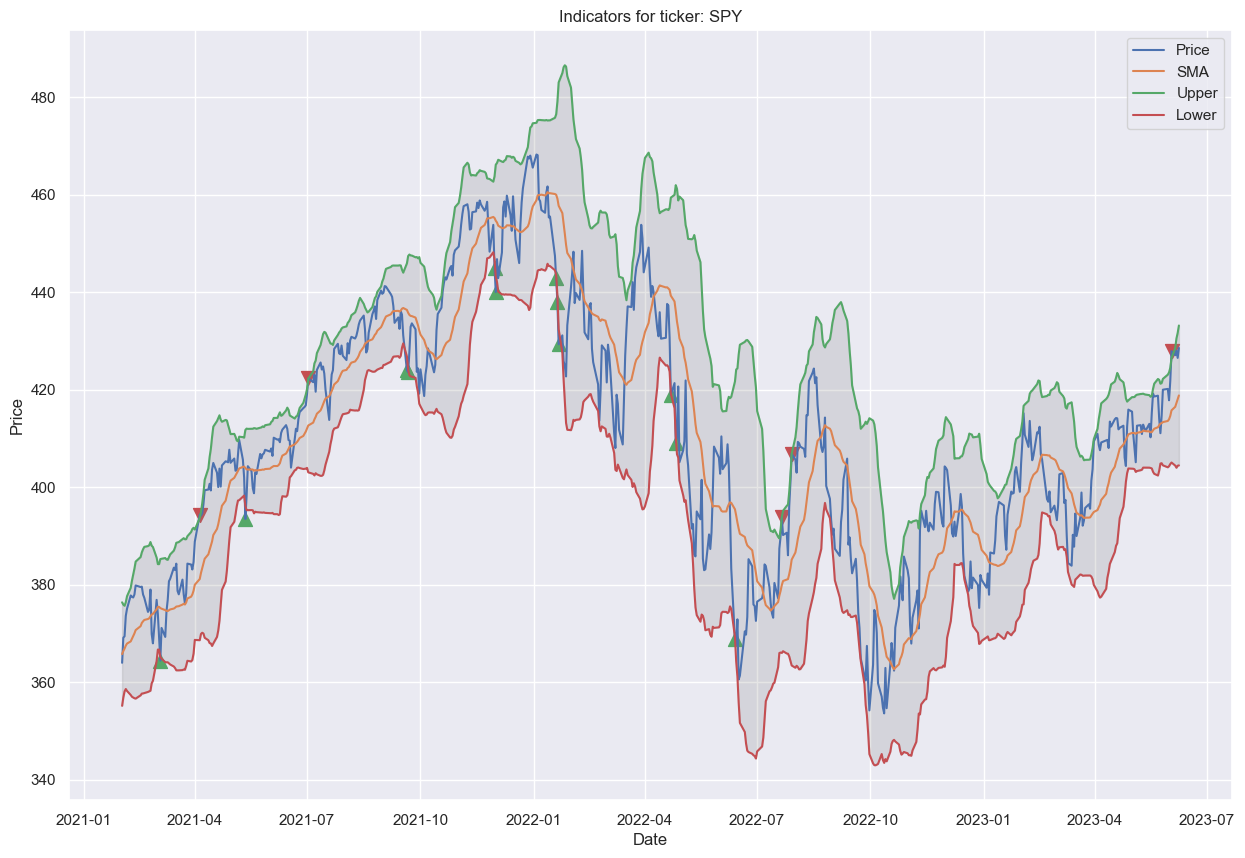

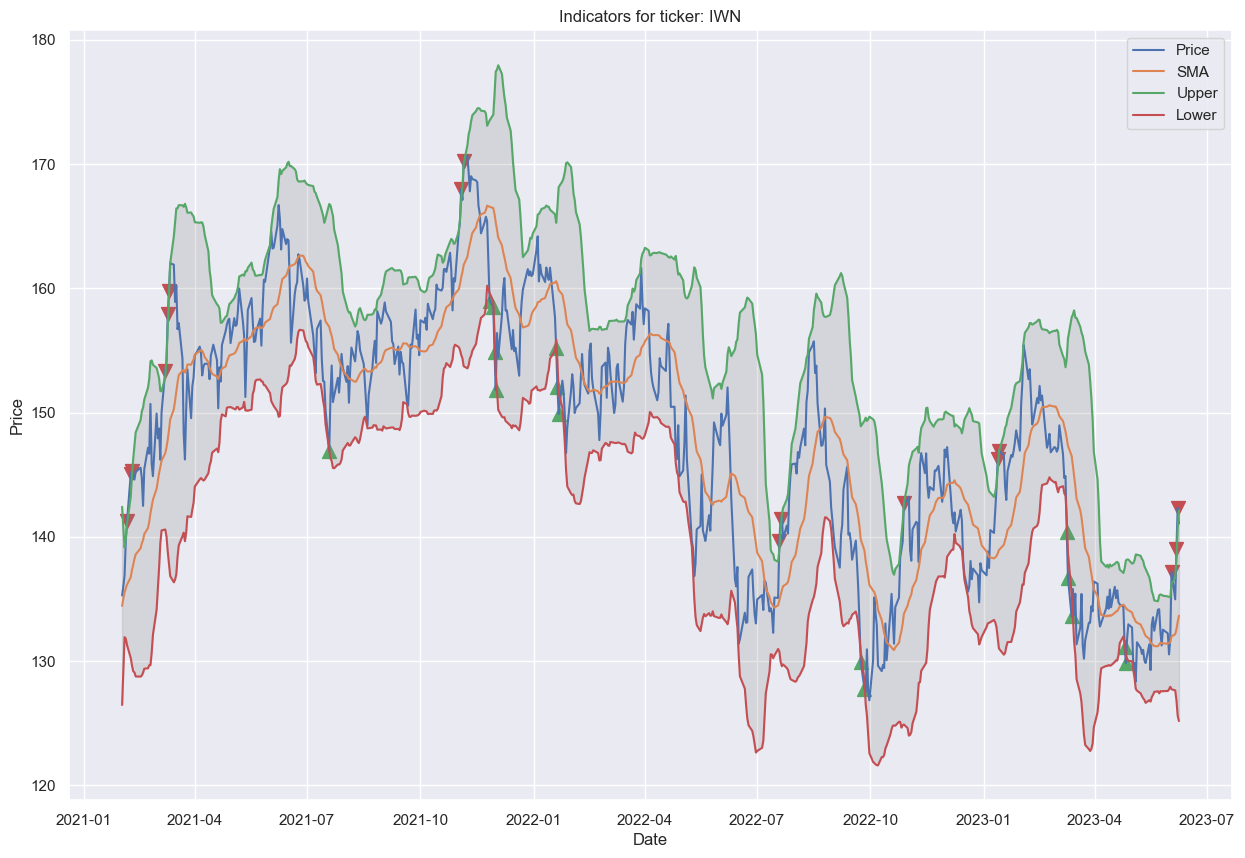

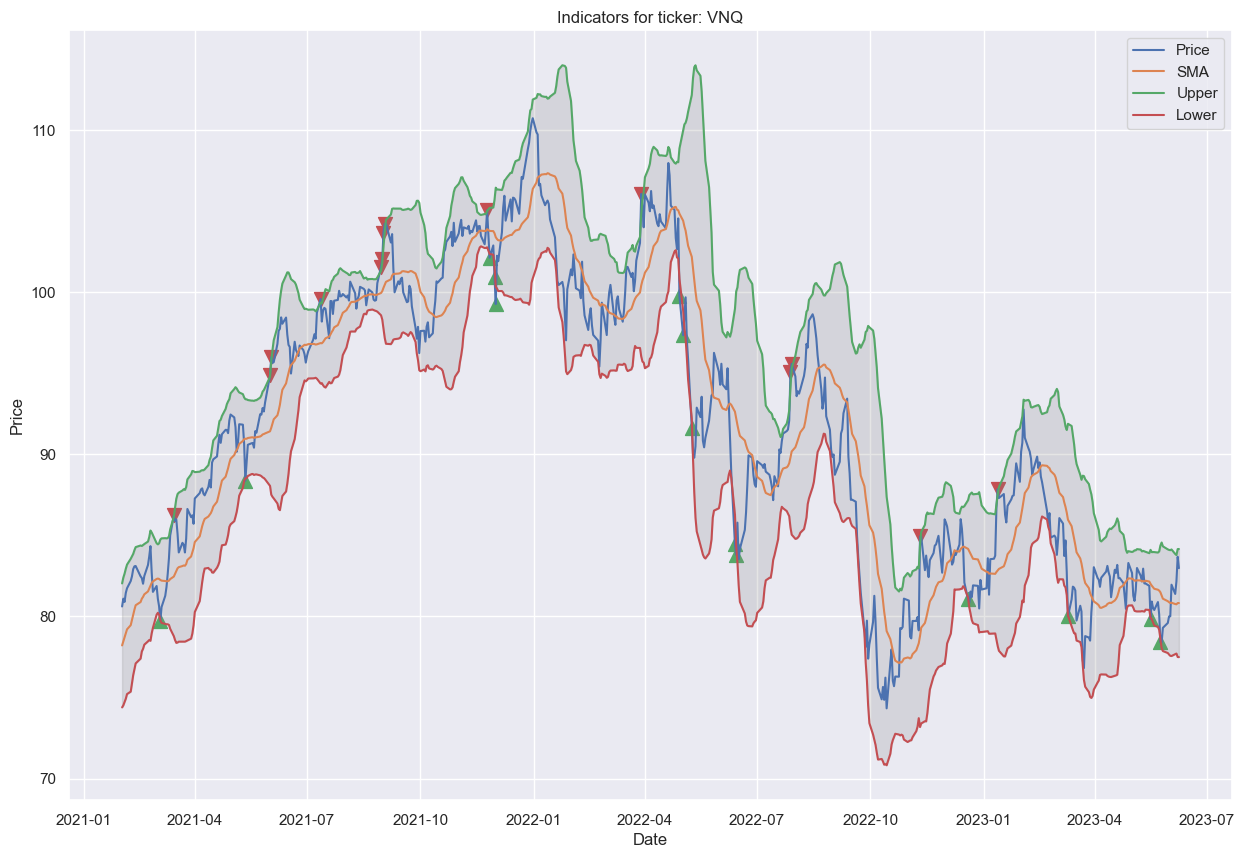

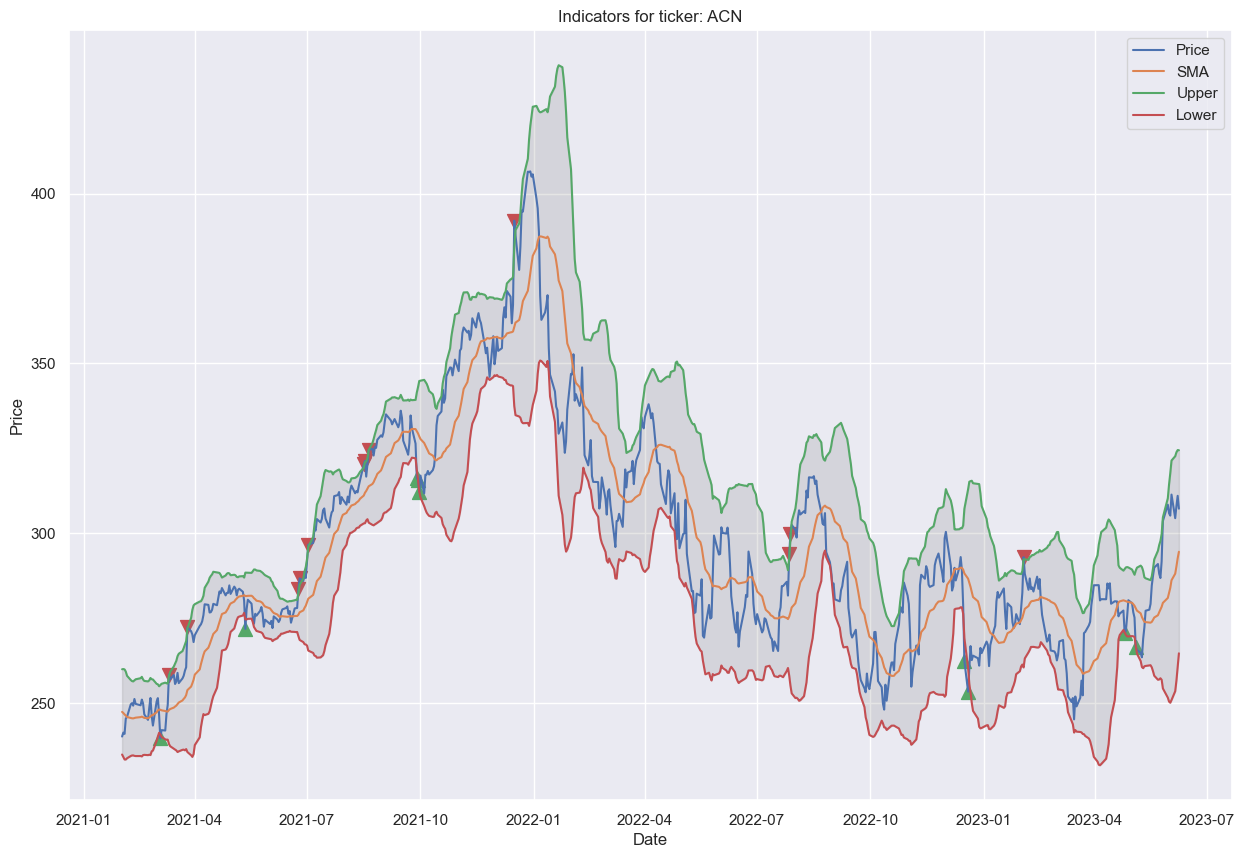

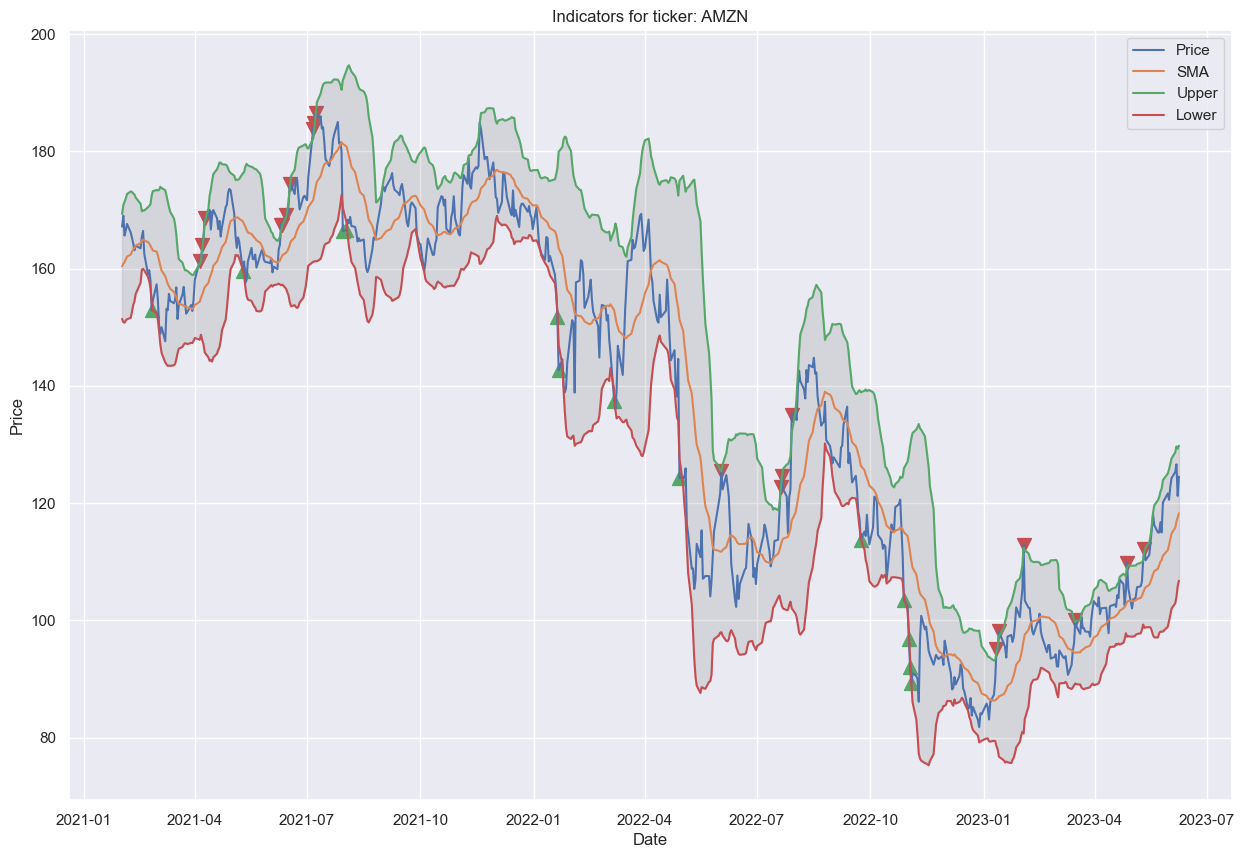

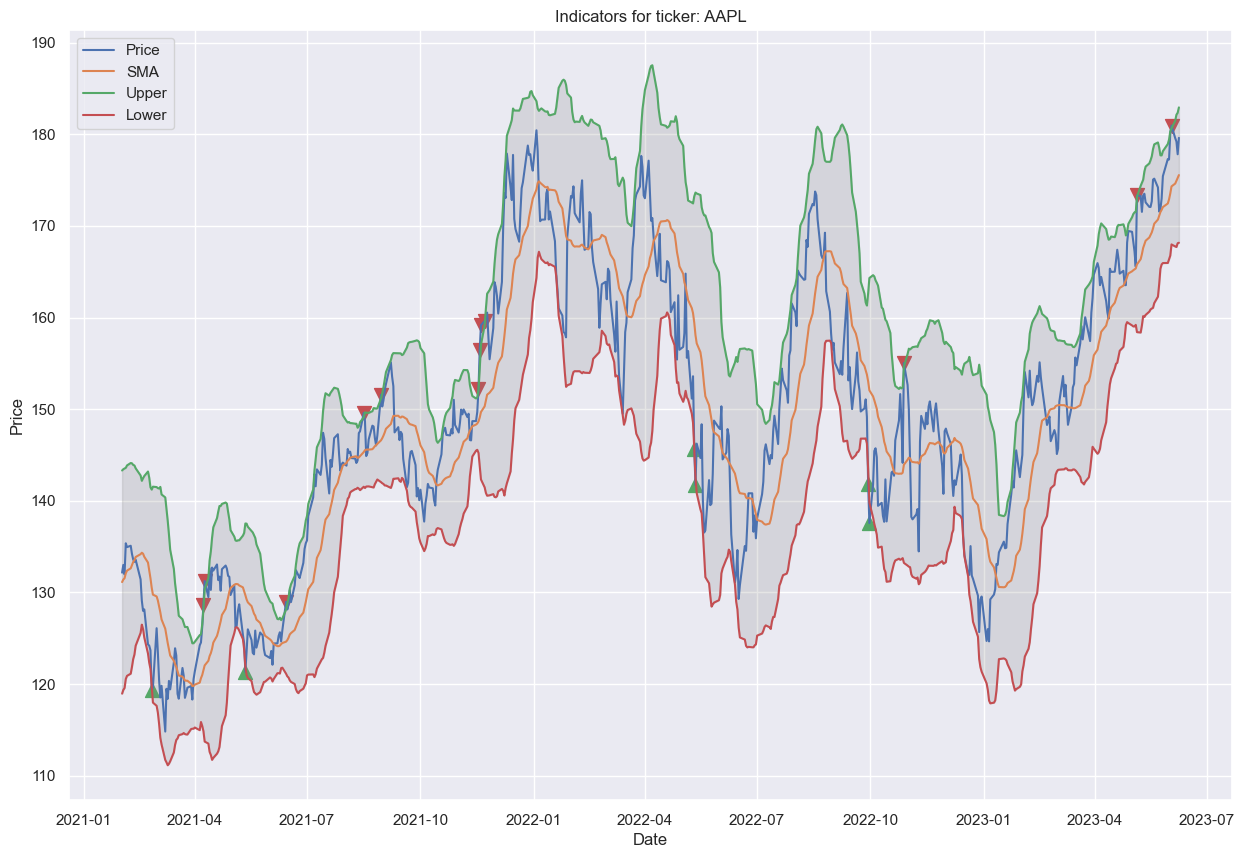

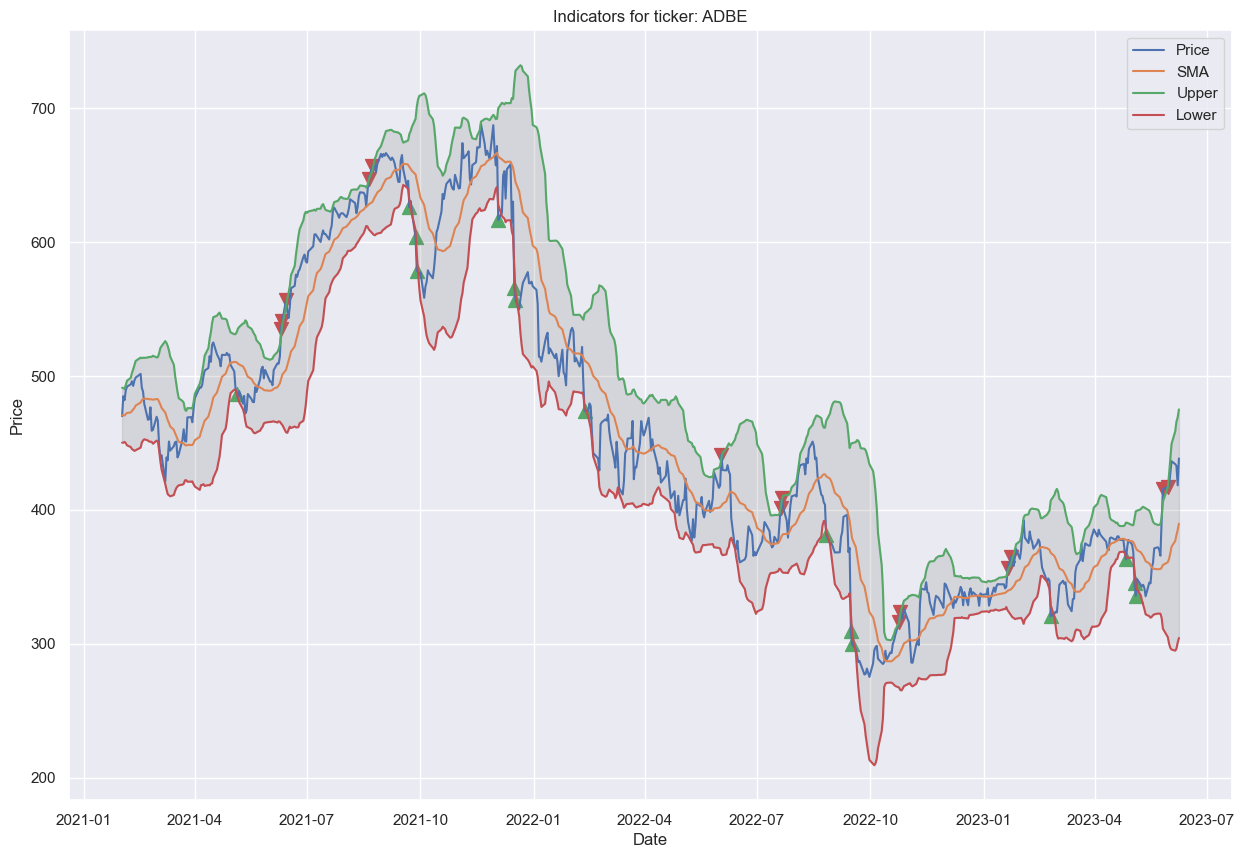

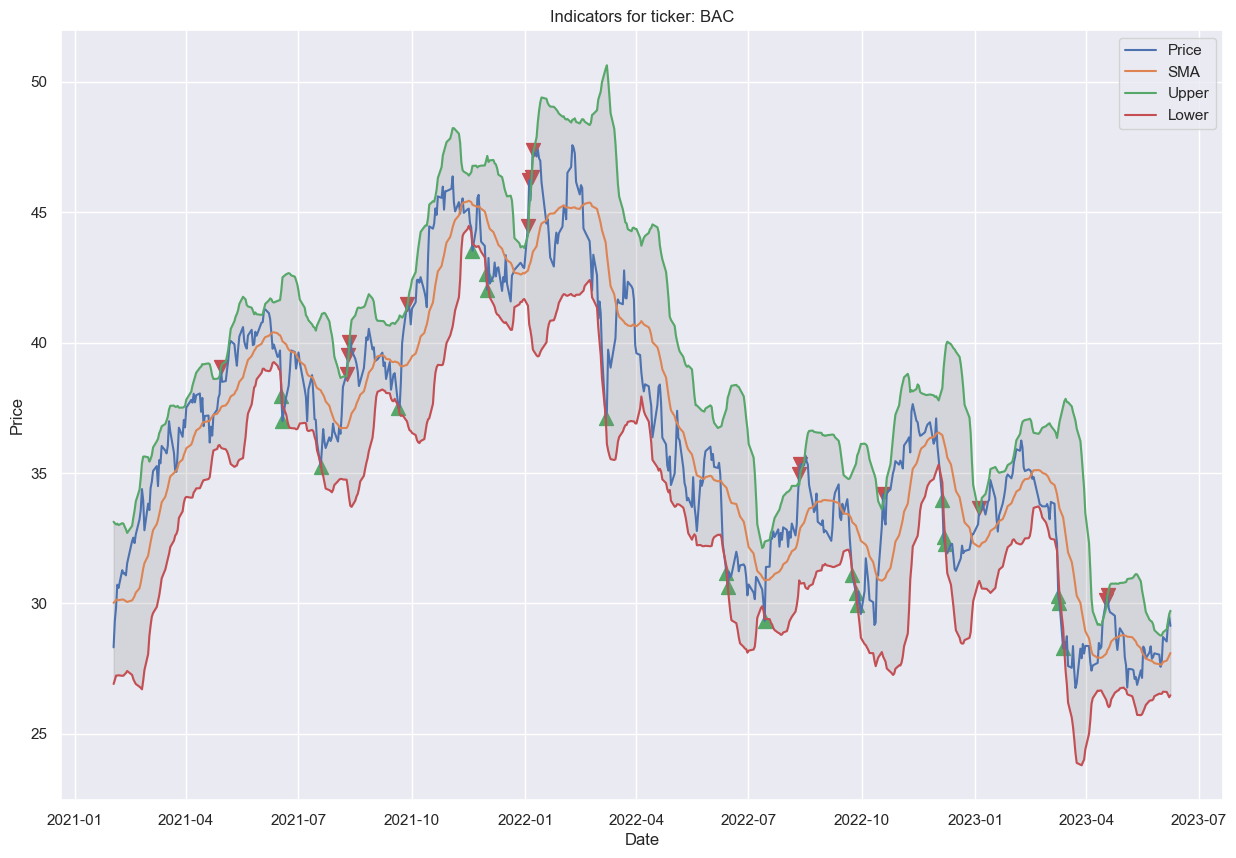

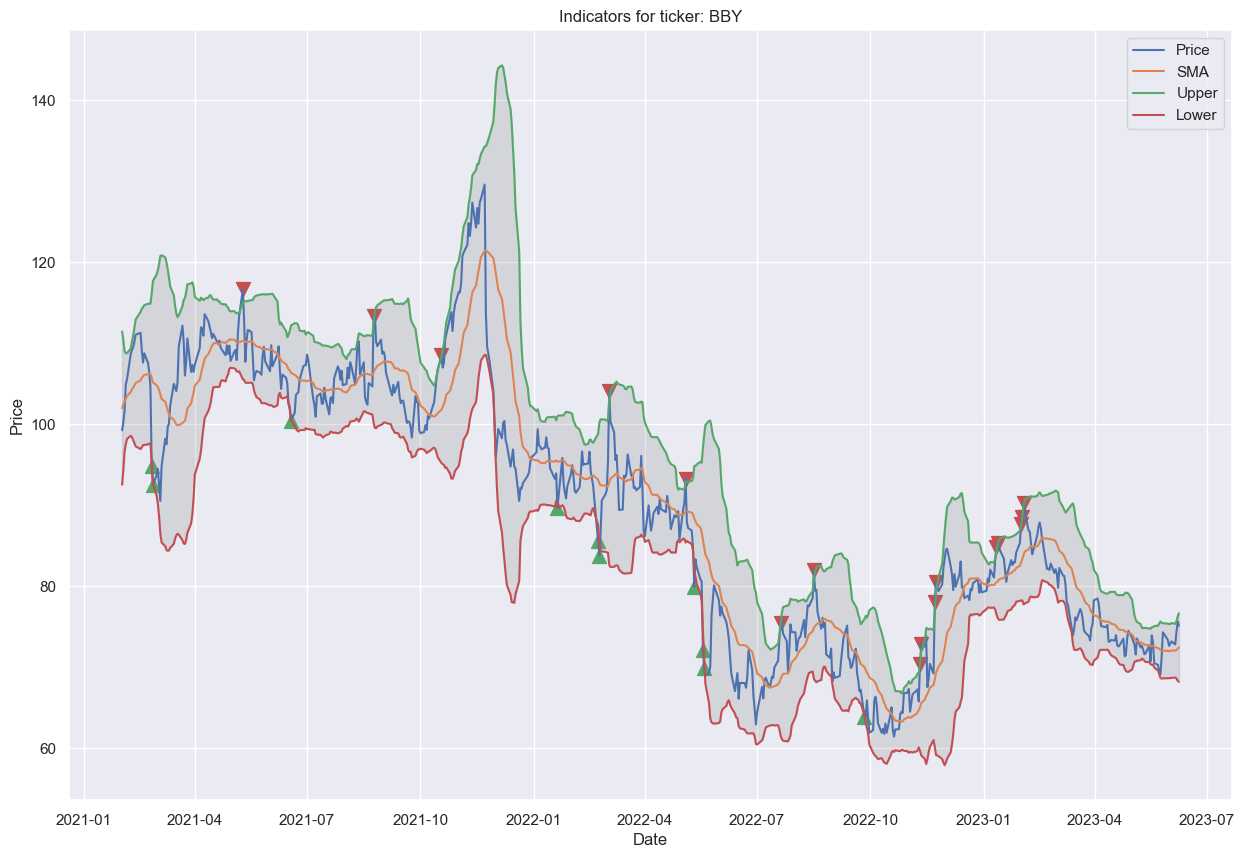

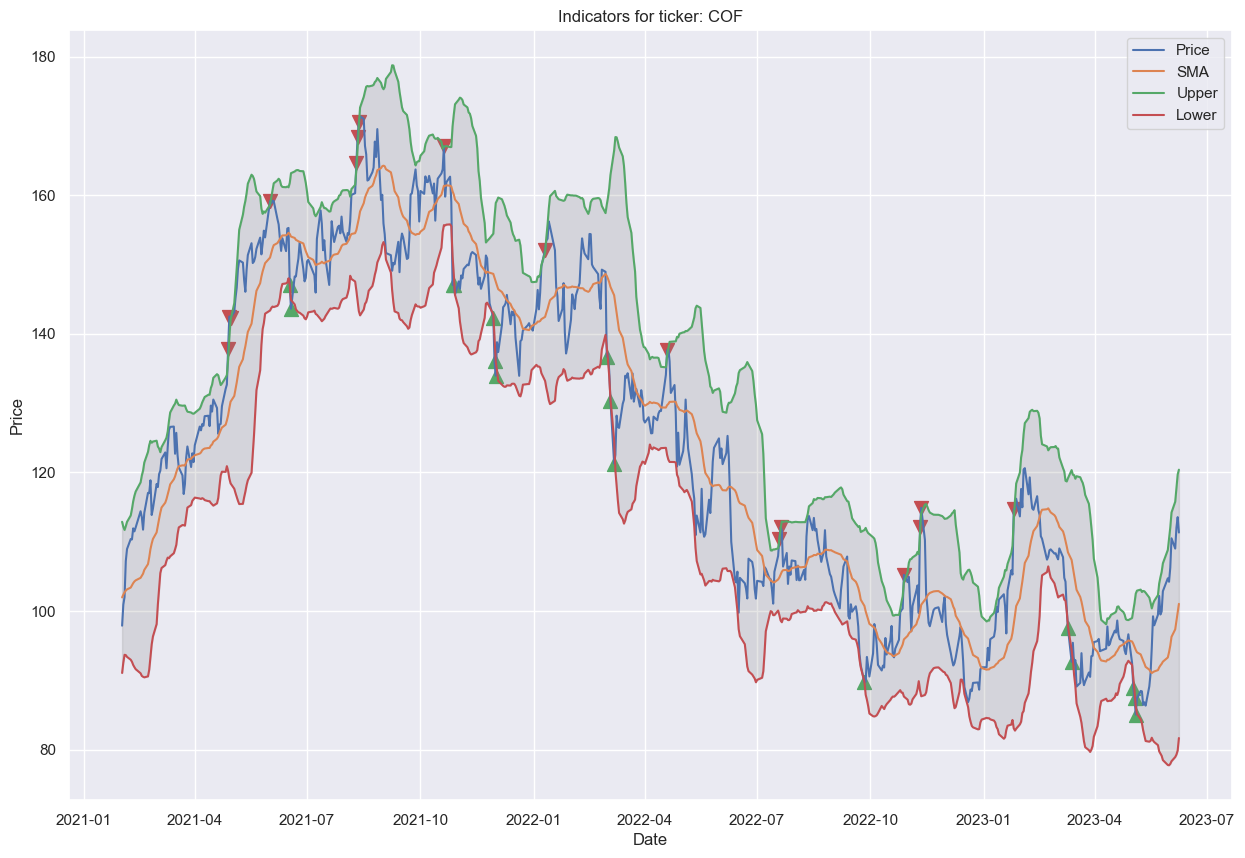

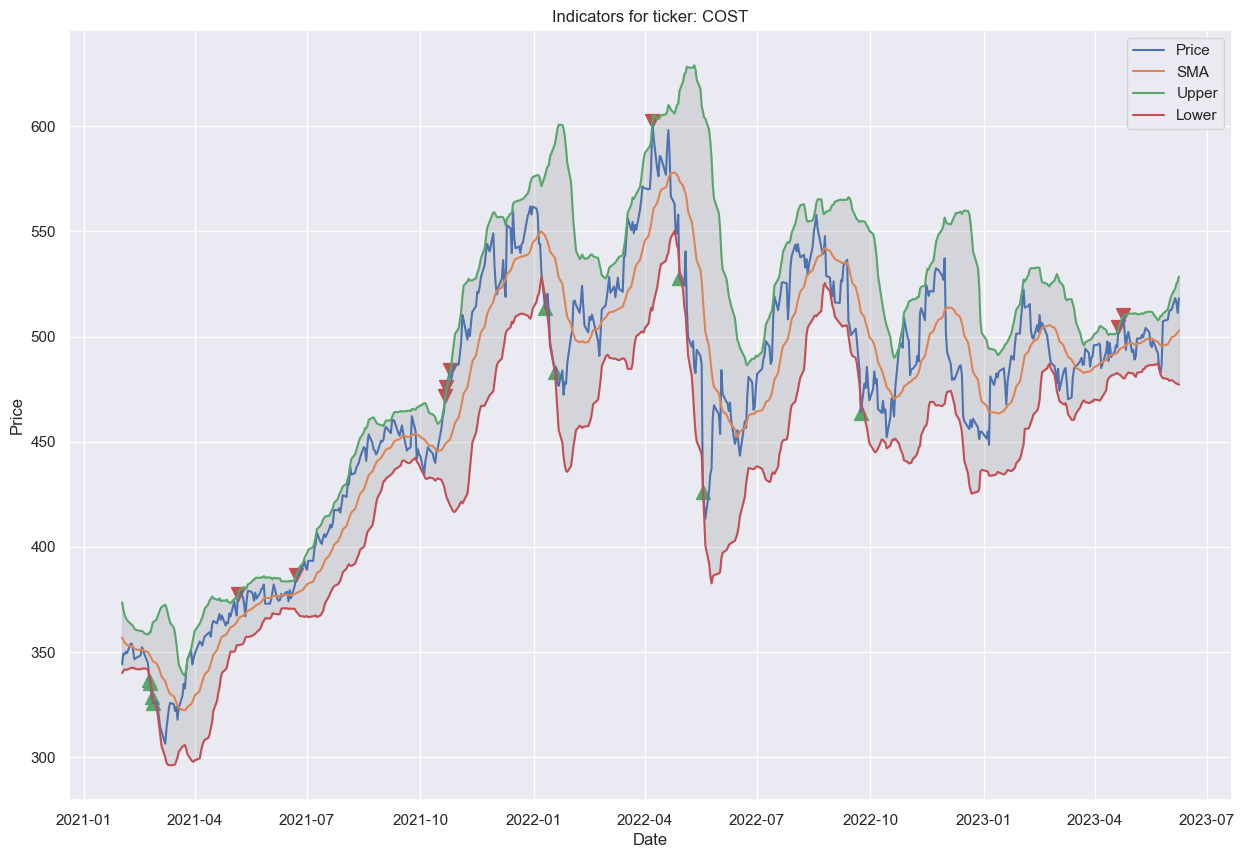

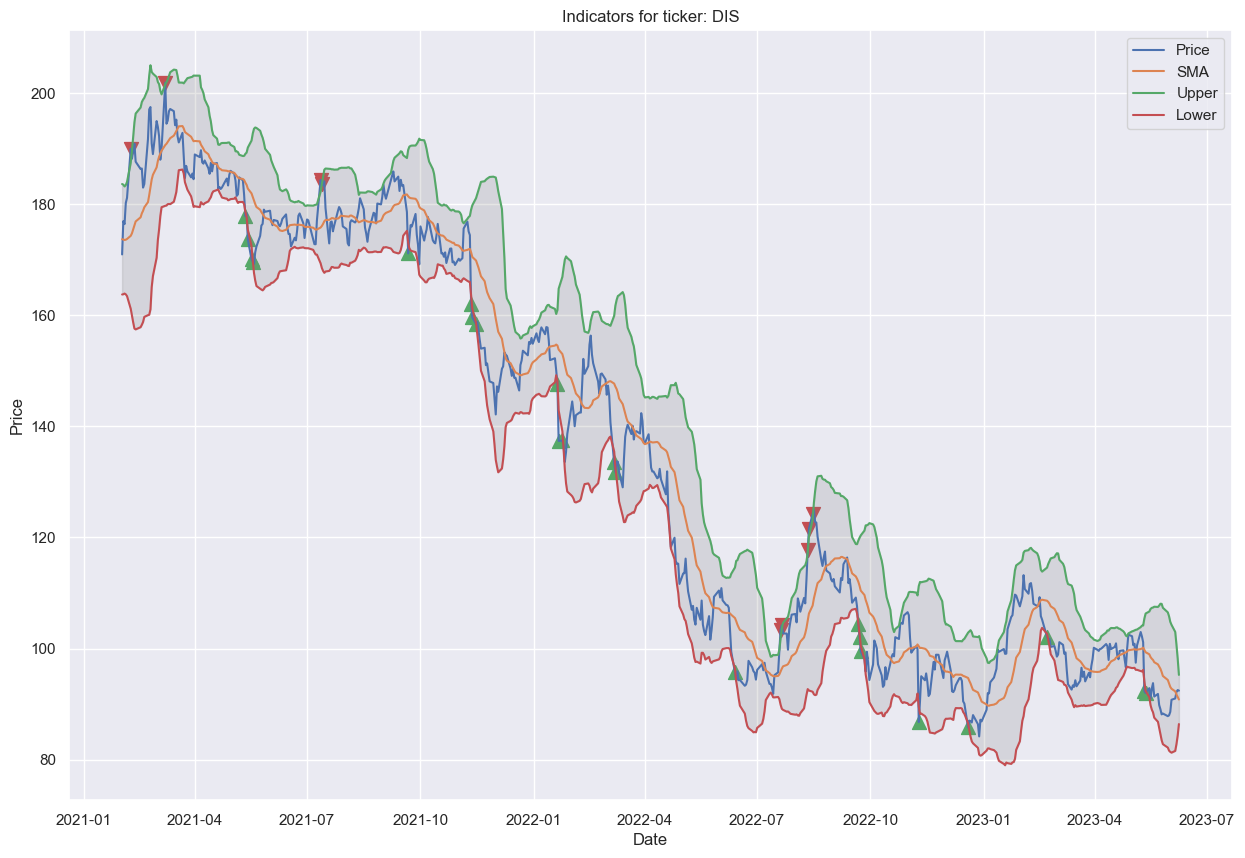

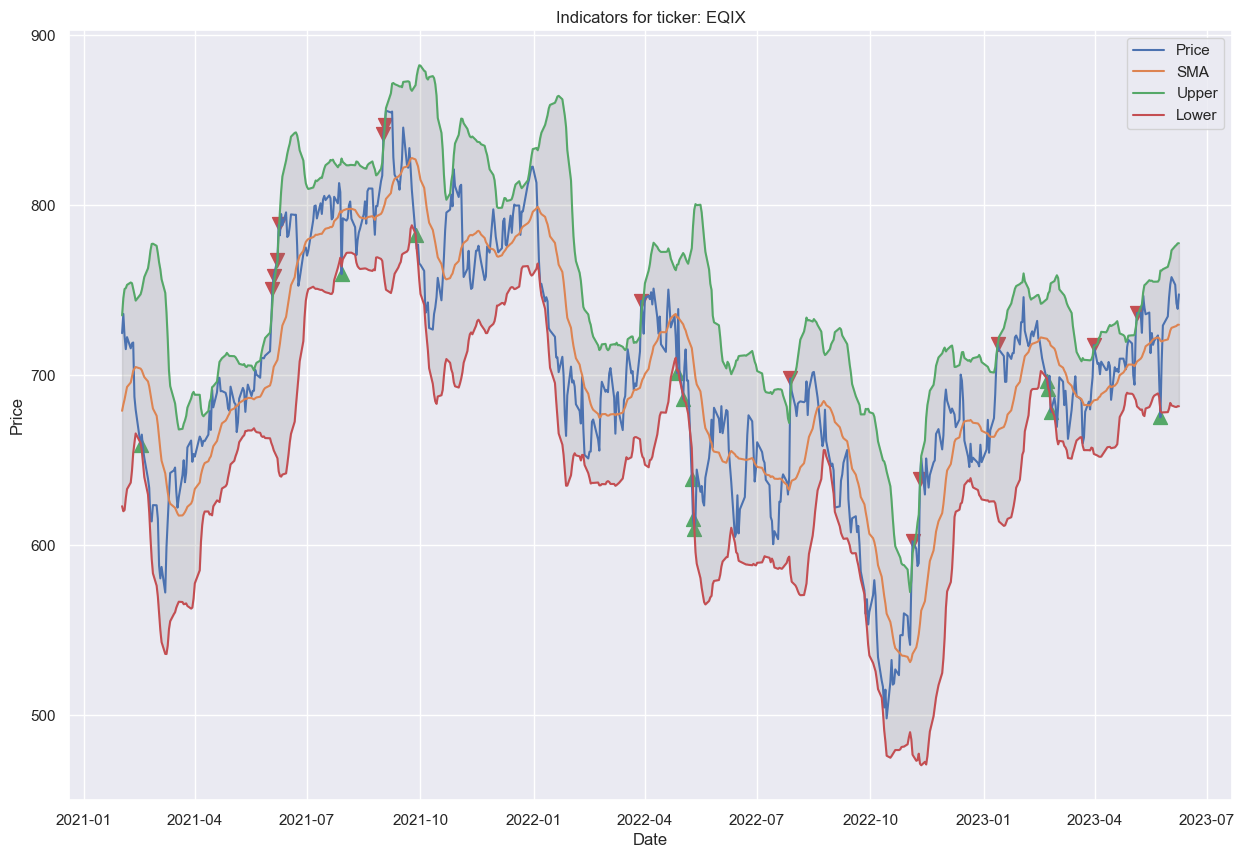

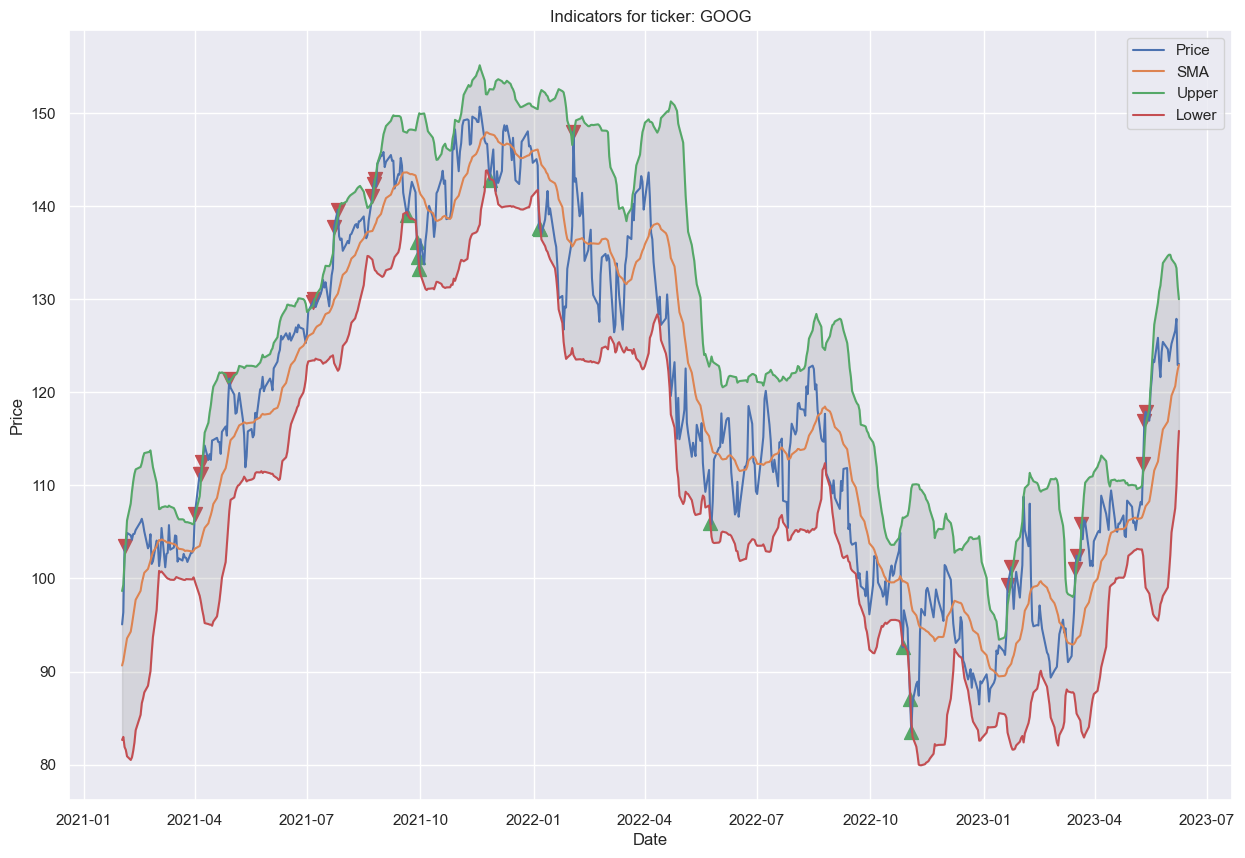

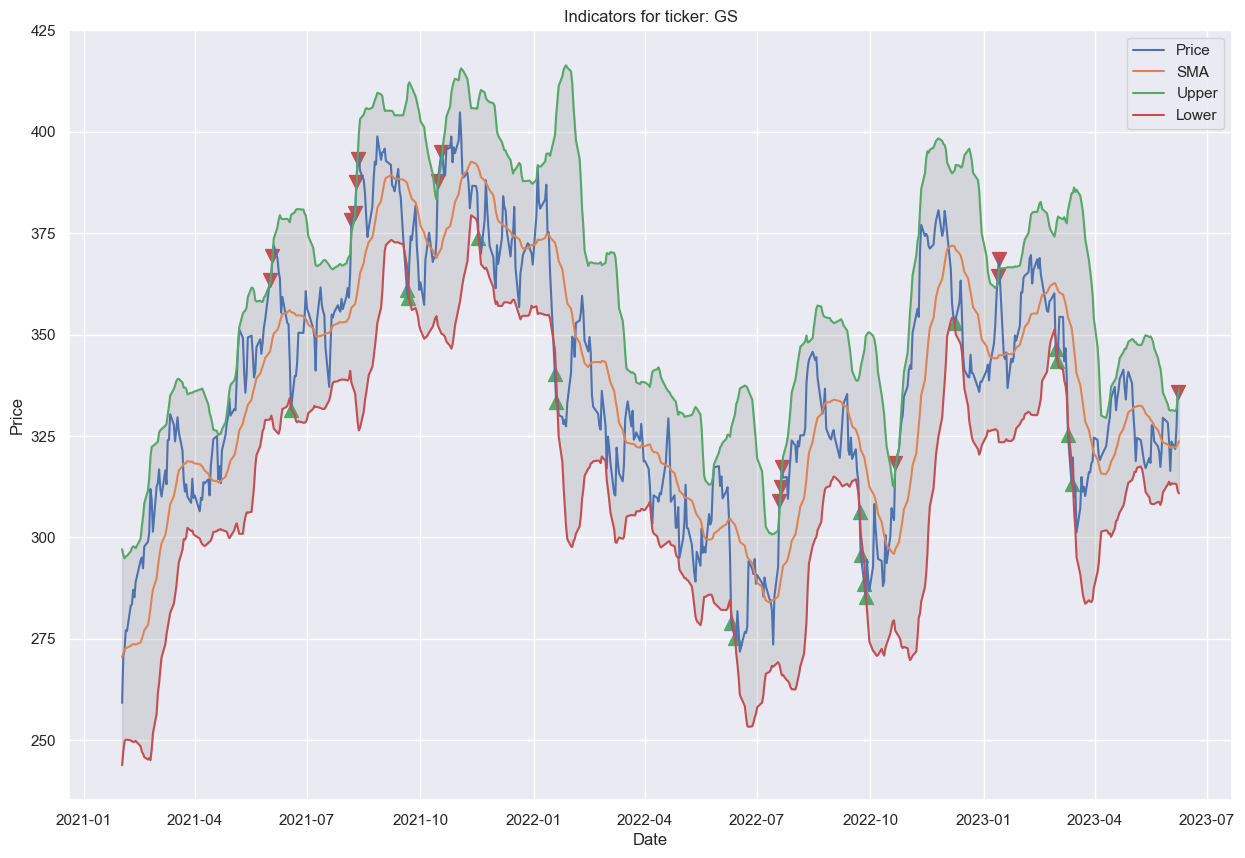

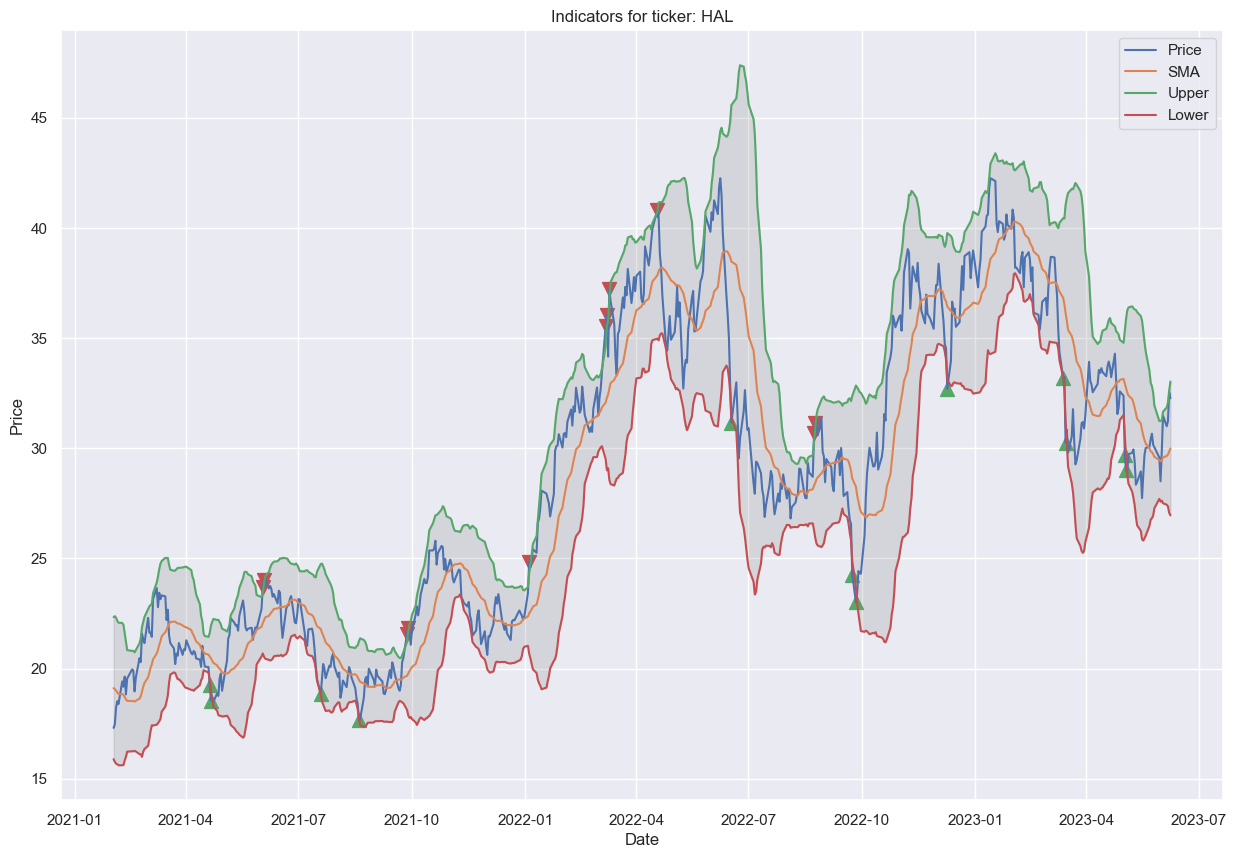

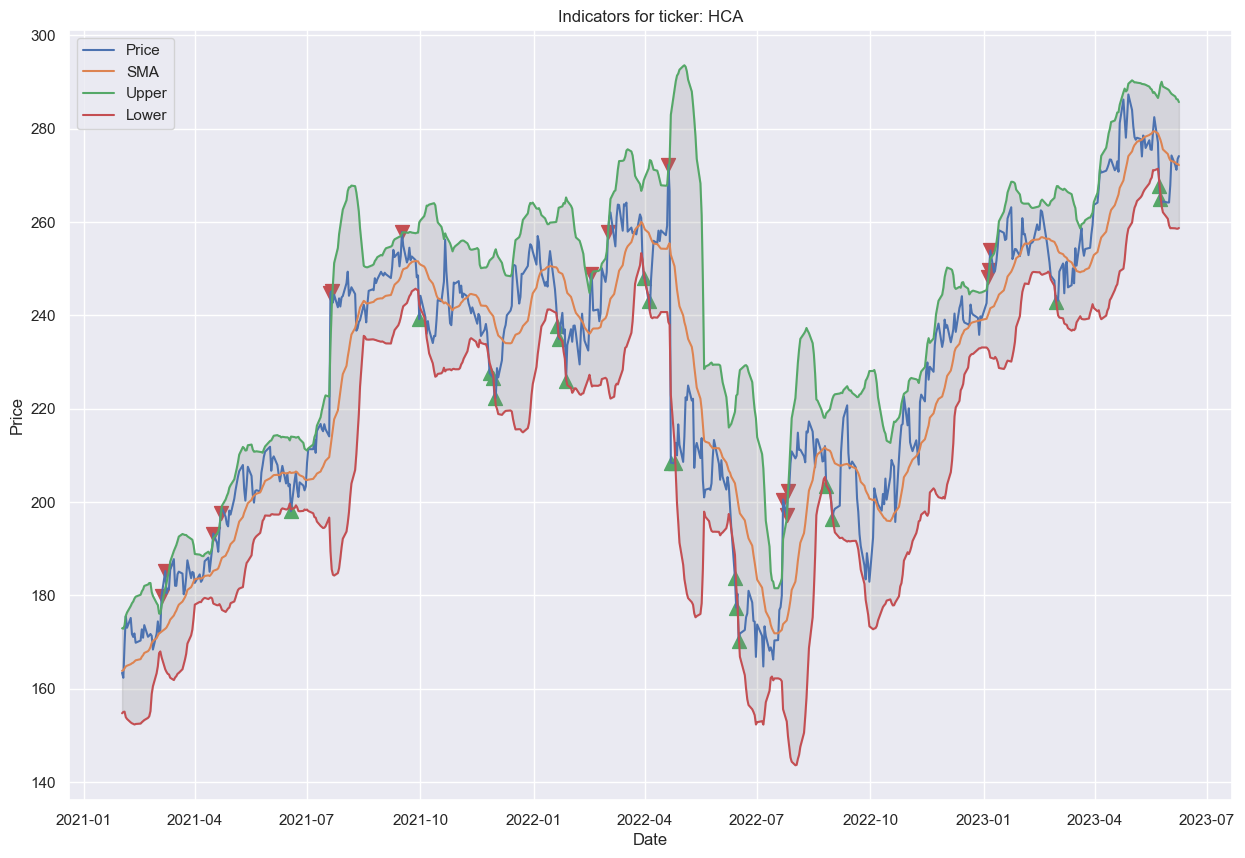

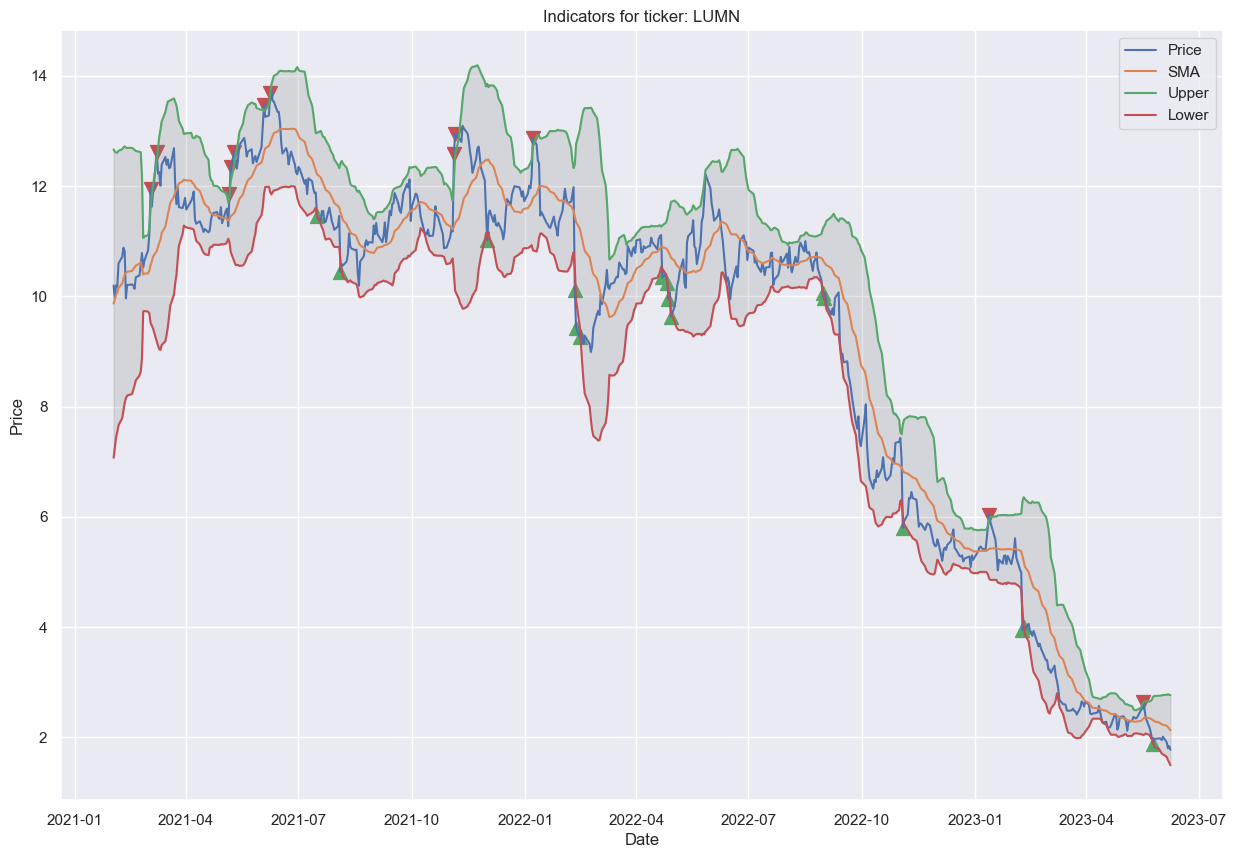

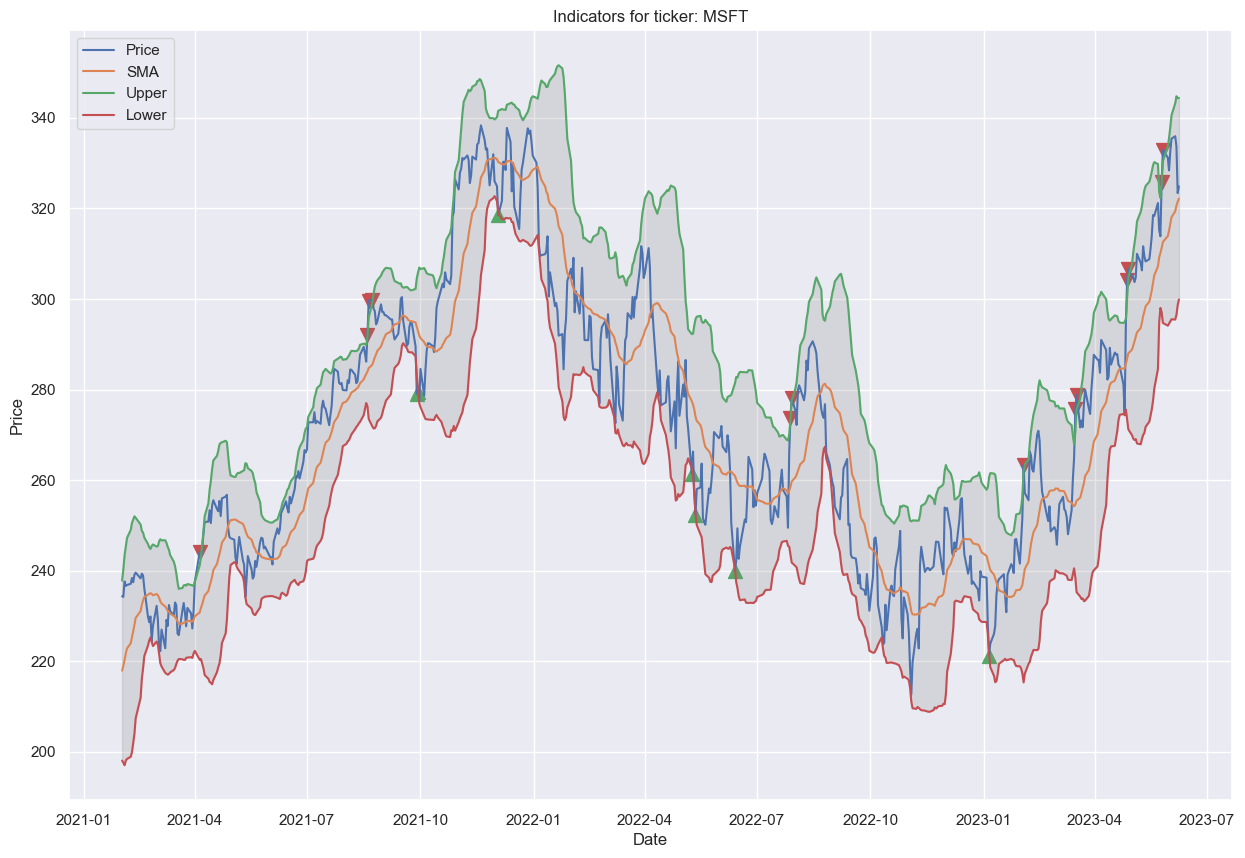

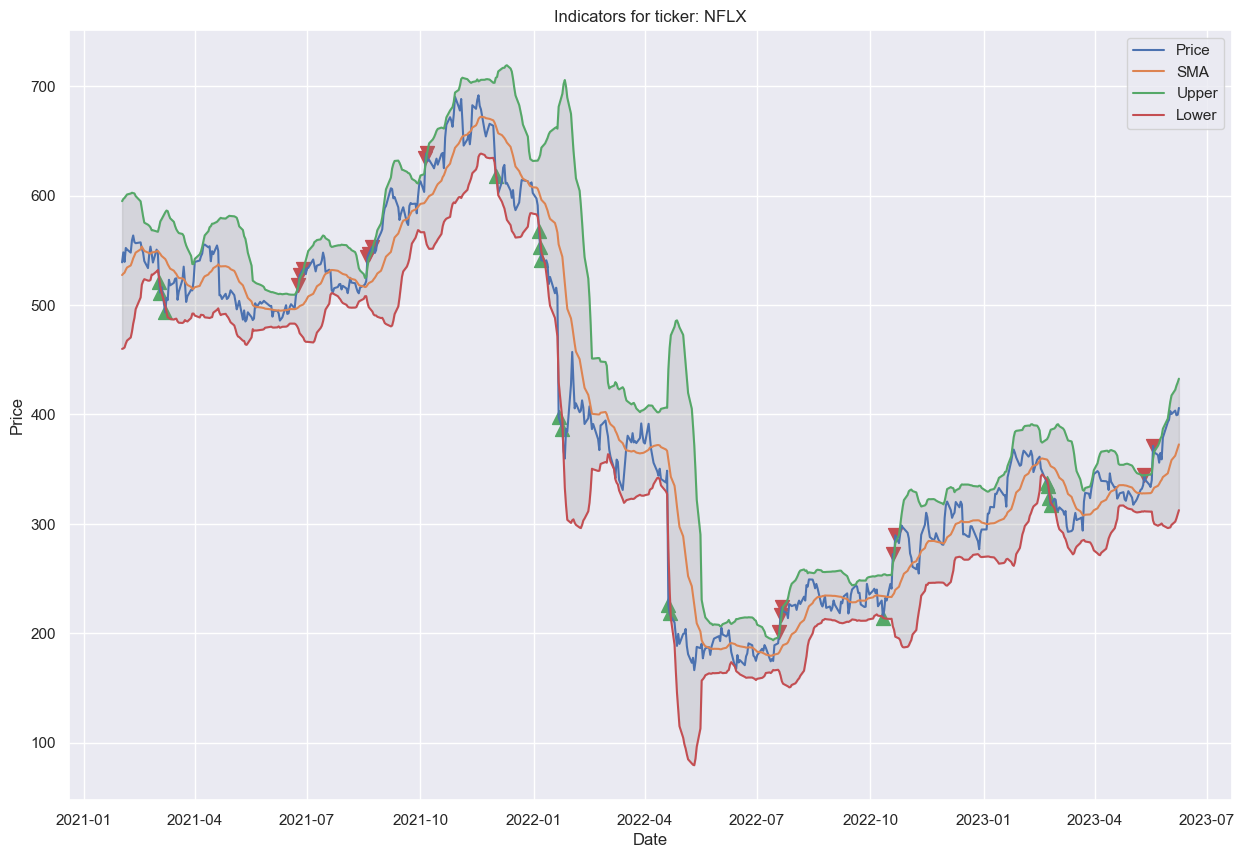

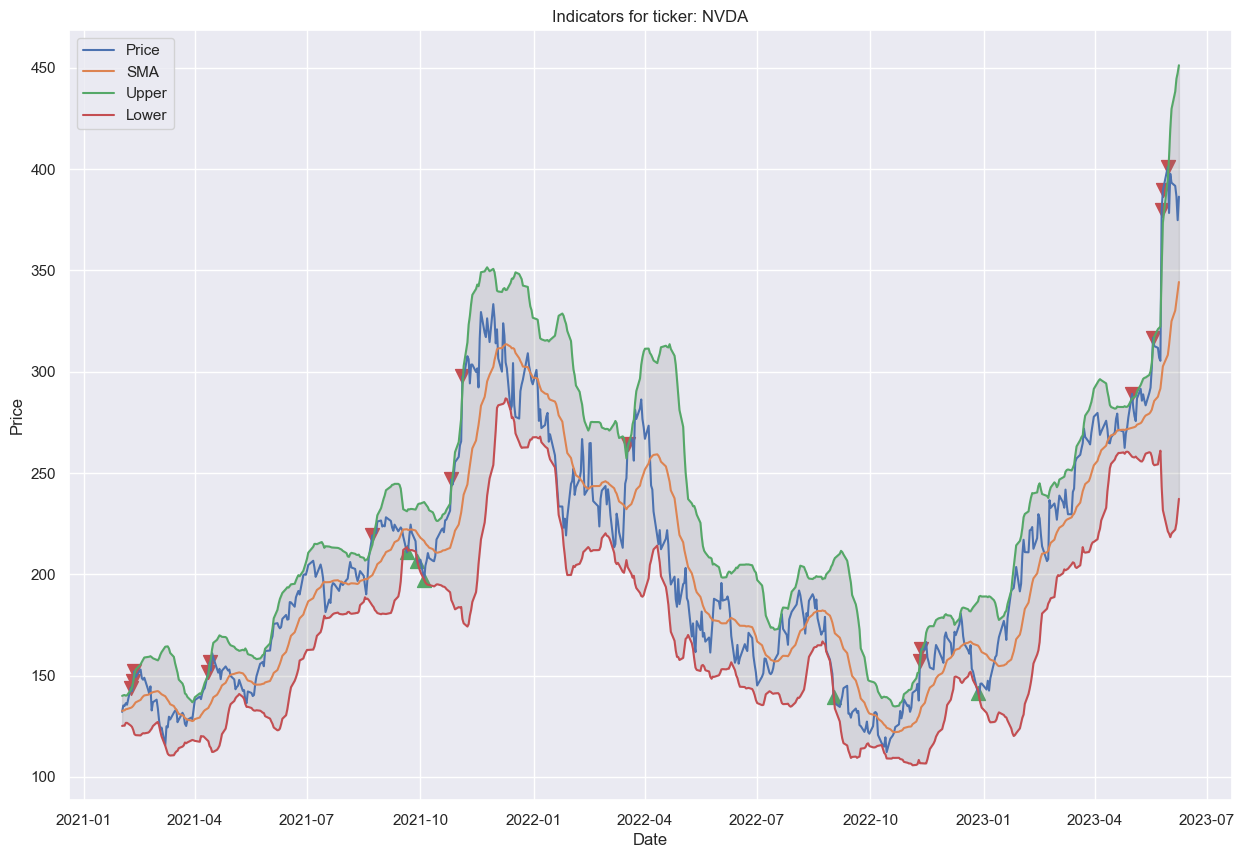

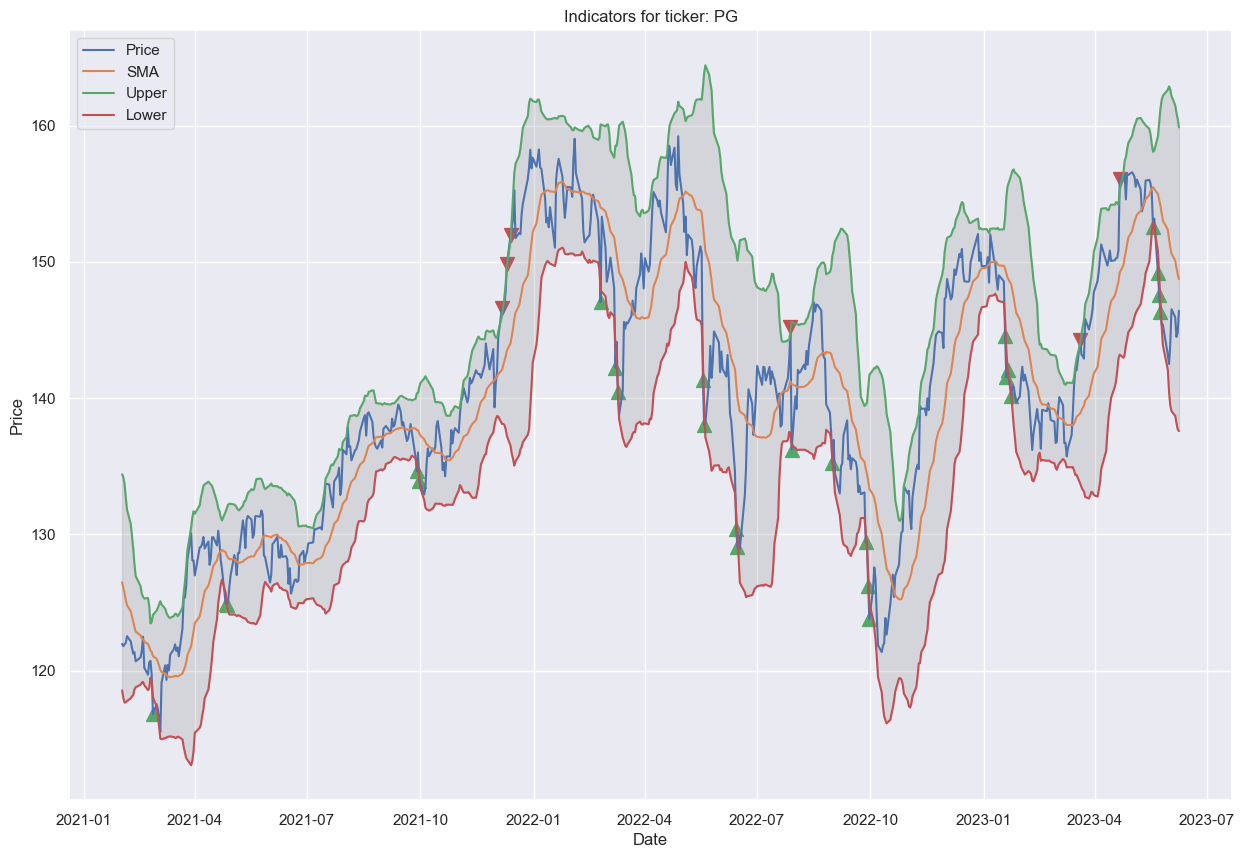

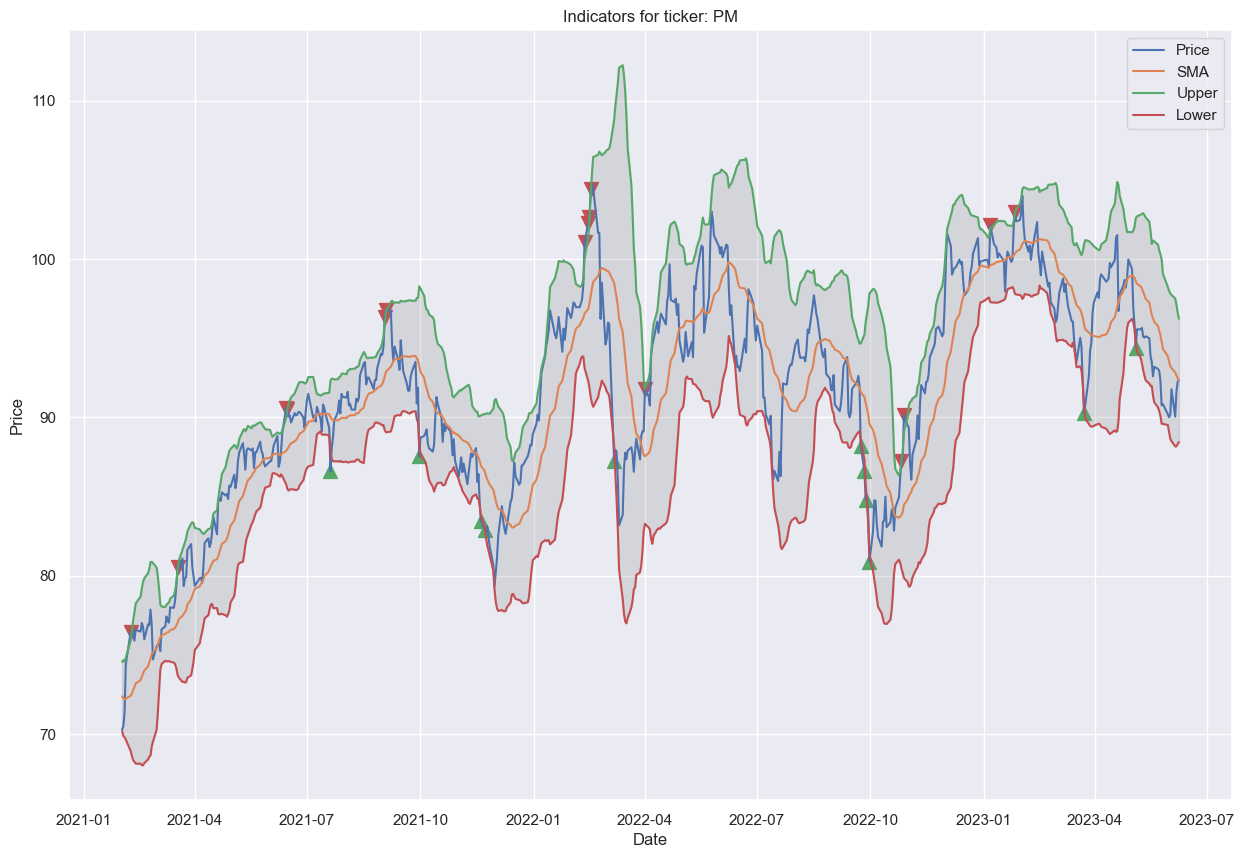

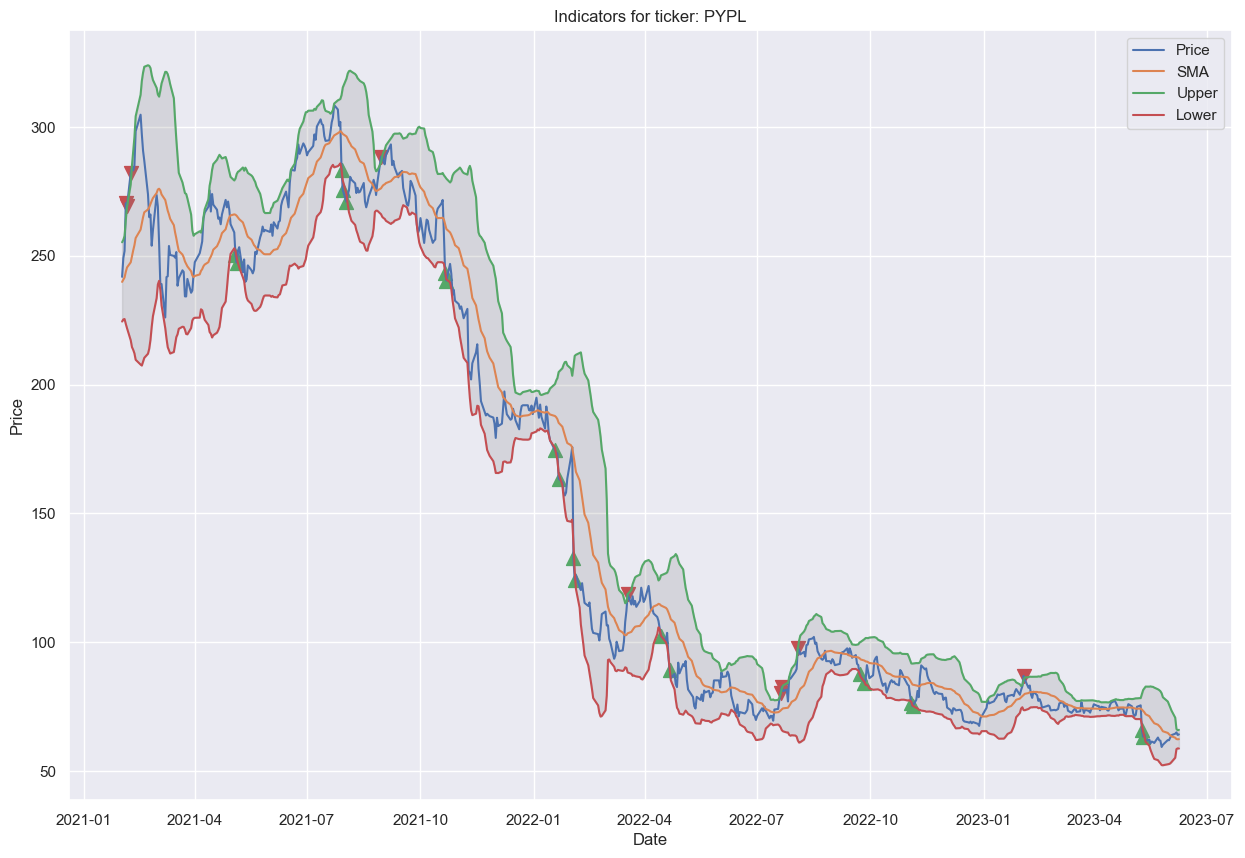

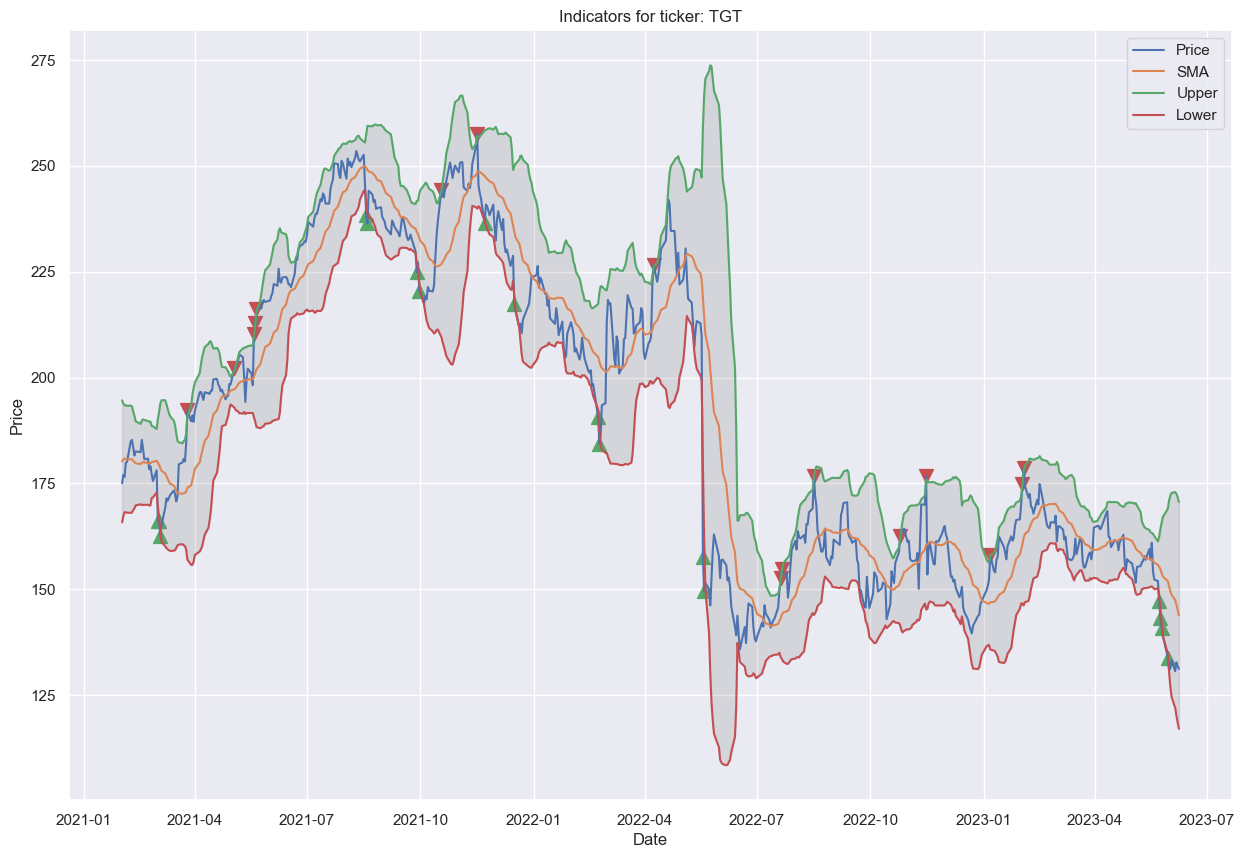

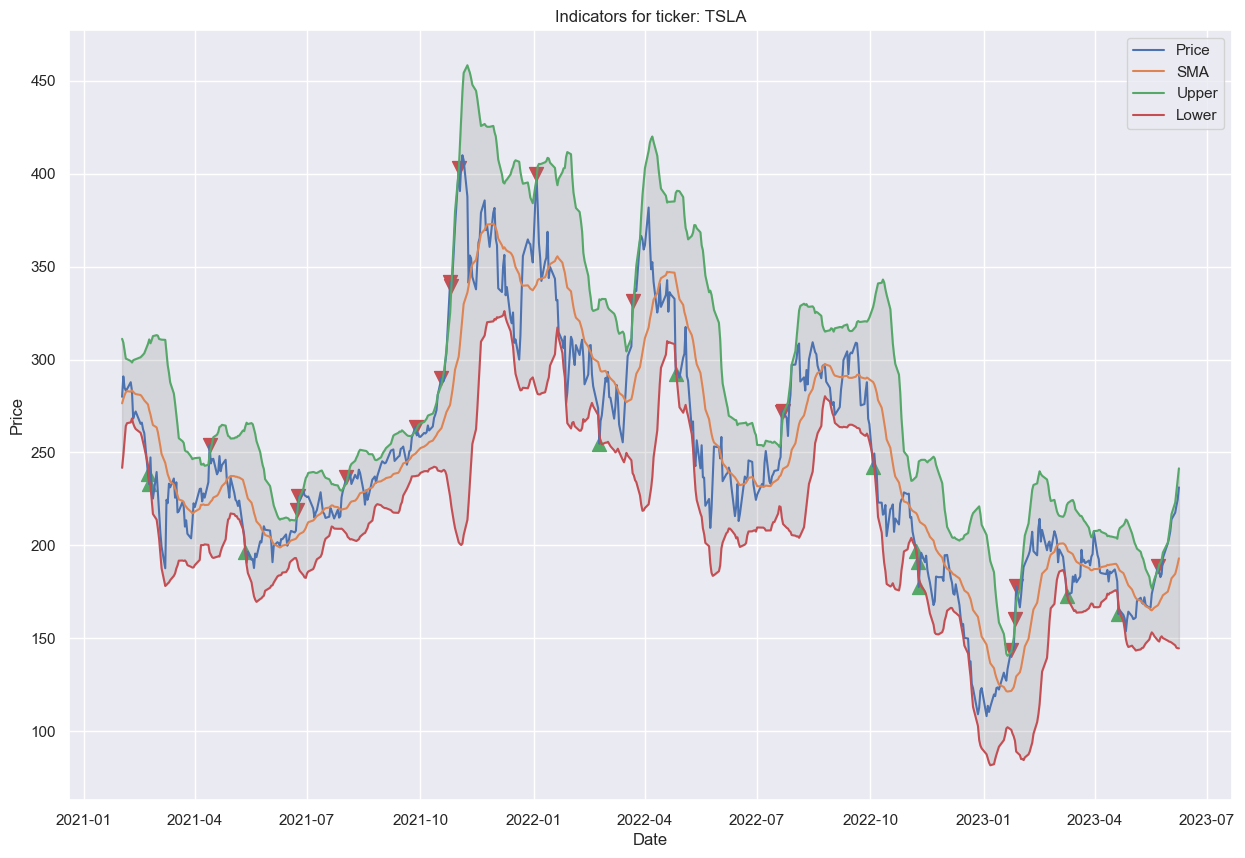

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime 
import plotly.express as px


def get_equity_hist(ticker):
    data = yf.Ticker(ticker).history(period="max")
    return data

def plotter(df, ticker):

    fig, ax = plt.subplots()
    fig.figsize=(20,12)

    ax.plot('Date', 'Close', data=df)

    plt.plot('Date', 'SMA', data=df) 
    plt.plot('Date', 'Upper', data=df) 
    plt.plot('Date', 'Lower', data=df) 
    
    plt.scatter('Date','Close', data=df[df['buysignal'] == True], marker = '^', color = 'g', s = 100) #X axis is date, Y axis is close price
    plt.scatter('Date','Close', data=df[df['sellsignal'] == True], marker = 'v', color = 'r', s = 100) #X axis is date, Y axis is close price
    plt.fill_between('Date','Upper','Lower',data=df,color = 'grey', alpha = 0.2)
    plt.legend(['Price','SMA','Upper','Lower'])
    plt.title('Indicators for ticker: ' + ticker)
    plt.xlabel('Date')
    plt.ylabel('Price')
    
    plt.savefig(ticker + '.png')
    plt.show()

def bollinger(df, num_stdev):
    df['SMA'] = df.Close.rolling(window = 20).mean()
    df['stddev'] = df.Close.rolling(window = 20).std()
    df['Upper'] = df.SMA + (num_stdev * df.stddev)
    df['Lower'] = df.SMA - (num_stdev * df.stddev)
    df['buysignal'] = np.where(df.Lower > df.Close, True, False)
    df['sellsignal'] = np.where(df.Upper < df.Close, True, False)
    df.dropna(inplace = True)

    return df

def add_rsi(df, field, periods = 14, ema = True):
    """
    Returns a pd.Series with the relative strength index.
    """
    close_delta = df[field].diff()

    # Make two series: one for lower closes and one for higher closes
    up = close_delta.clip(lower=0)
    down = -1 * close_delta.clip(upper=0)
    
    if ema == True:
        # Use exponential moving average
        ma_up = up.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()
        ma_down = down.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()
    else:
        # Use simple moving average
        ma_up = up.rolling(window = periods, adjust=False).mean()
        ma_down = down.rolling(window = periods, adjust=False).mean()
        
    rsi = ma_up / ma_down
    rsi = 100 - (100/(1 + rsi))
    df['rsi'] = rsi
    return df

def calculate_returns(pxs):
    returns = []
    current_return = None
    print(len(pxs))
    for i in range(2,len(pxs)):
        current_return = (pxs[i] - pxs[i-1]) / pxs[i-1]
        returns.append(current_return)
    return returns

class equity_summary:

    def __init__(self, data, start_date, num_stdev):
        df_price_hist = get_equity_hist(data)
        df_price_hist.reset_index(inplace=True)
        df_price_hist['Date'] = pd.to_datetime(df_price_hist['Date'], utc=True)
        df_price_hist = df_price_hist[df_price_hist['Date'] >= start_date]
        df_price_hist.reset_index(inplace=True, drop=True)

        if(~df_price_hist.empty):
            self.df = df_price_hist
            self.prices = self.df['Close']
            self.df['returns'] = self.df['Close'].pct_change(1) 
            self.df['returns_multiplier'] = 1 + self.df['returns']
            self.df = bollinger(self.df, float(num_stdev))
            self.ticker = str(data)
        else:
            self.df = pd.DataFrame()
    
    def plot_history(self):

        if(self.df.empty == False):
            sns.set()
            sns.set(rc={'figure.figsize':(15,10)})
            plotter(self.df, self.ticker)  
        else:
            pass
        
dict_equity = {}

for s in my_stocks:
  dict_equity[s] = equity_summary(s, '2021-01-01',2.33)
  dict_equity[s].plot_history()